In [1]:
"""
In this nb, we are generating a Time Series which consists of different components like:
1.Trend - An increasing or decreasing trend in value with time
2.Seasonality - Periodically repeating pattern in value with time
3.Noise - Randomness of value with time
Using that time series we perform forecasting for future time values
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

In [2]:
# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

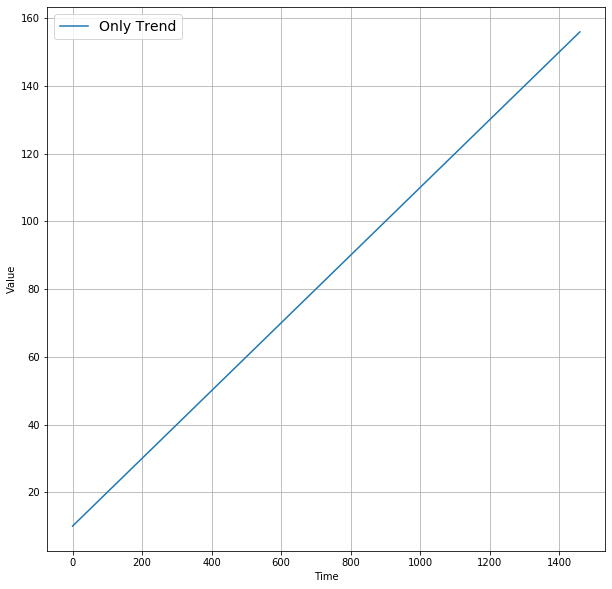

In [3]:
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series which only has Trend for now
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 
series = baseline + trend(time,0.1)

# Plotting the trend
plt.figure(figsize=(10,10))
plot_series(time,series,label="Only Trend")
# plt.show()

In [4]:
print(time,series)

[   0    1    2 ... 1458 1459 1460] [ 10.   10.1  10.2 ... 155.8 155.9 156. ]


In [5]:
# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

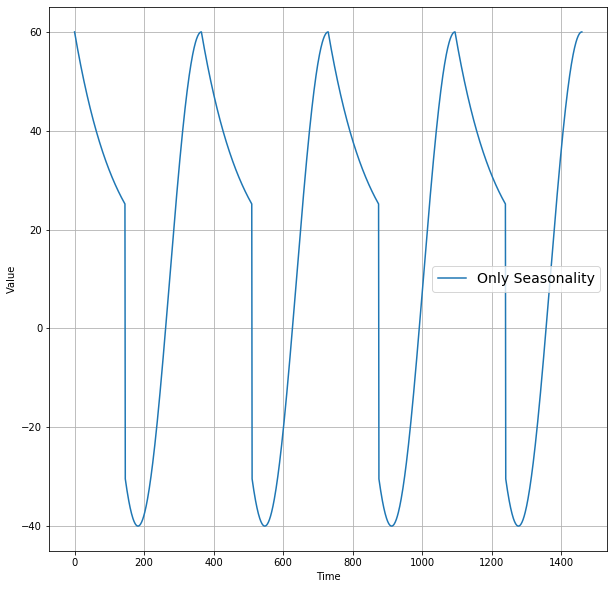

In [6]:
# Plotting Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline
plt.figure(figsize=(10,10))
plot_series(time,series,label="Only Seasonality")

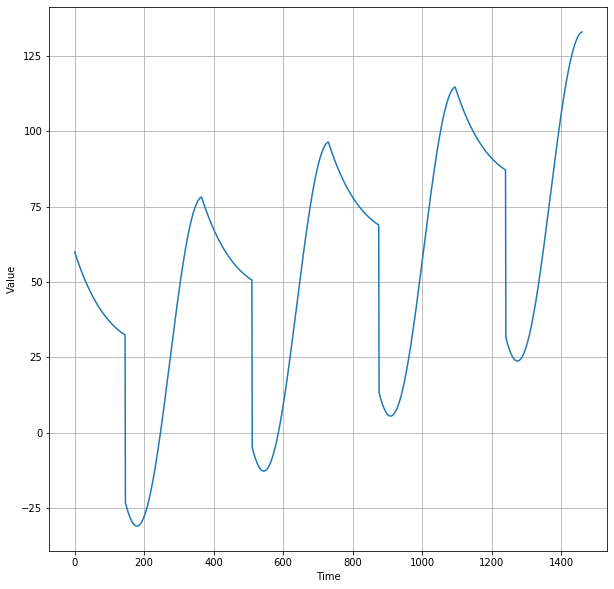

In [7]:
# Plotting seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)
plt.figure(figsize=(10,10))
plot_series(time,series)

In [8]:
# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

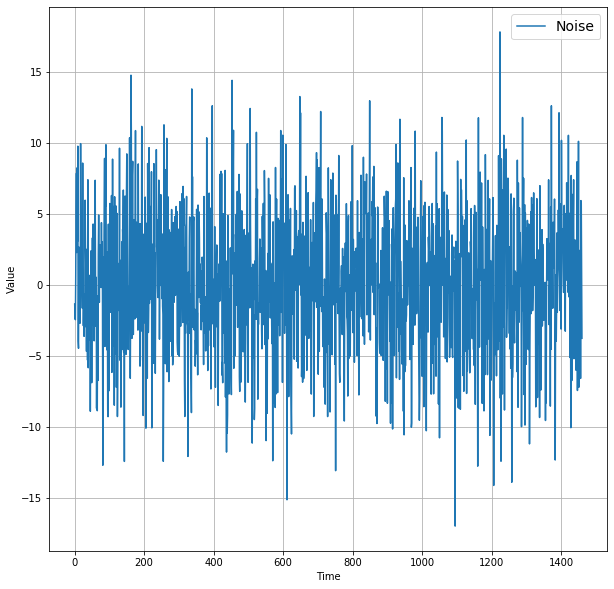

In [9]:
noise_level = 5
noise = white_noise(time,noise_level)
plt.figure(figsize=(10,10))
plot_series(time,noise,label="Noise")

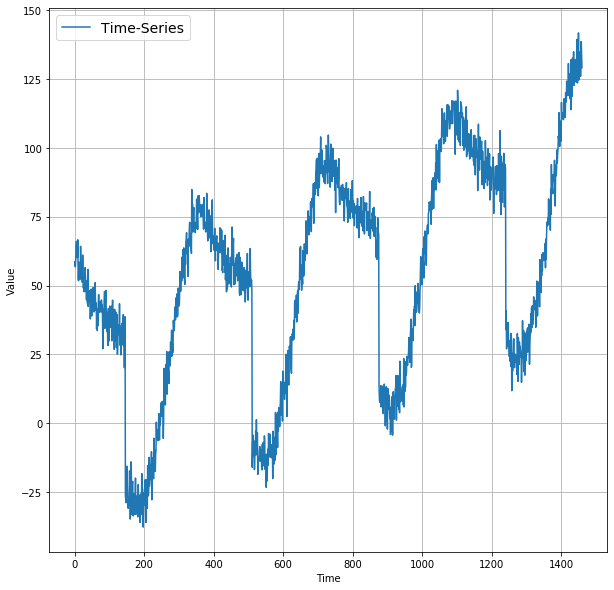

In [10]:
# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

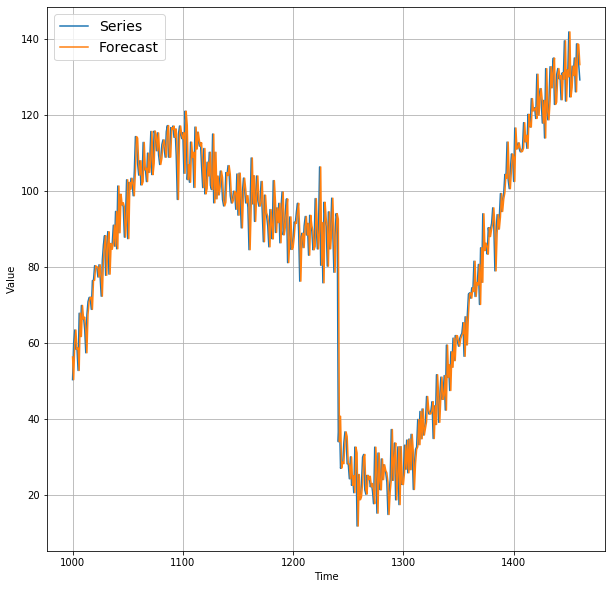

In [11]:
# In the Naive Forecasting, we just copy the previous value of time-series to the current time.
# For naive forecasting, split time-series into training and validation period. Splitting starts at 1000
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# -1 to consider values only upto values before the last value
naive_forecast = series[split_time-1:-1]
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,naive_forecast,label="Forecast")

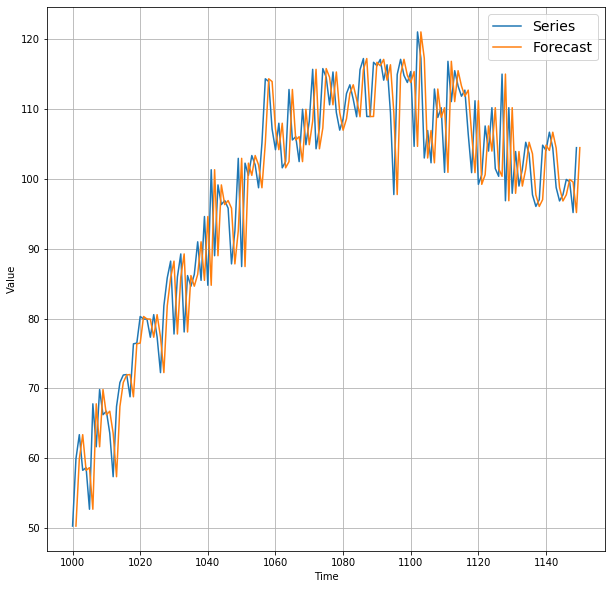

In [12]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,start=0,end=150,label="Series")
plot_series(time_valid,naive_forecast,start=1,end=151,label="Forecast")

In [13]:
keras.metrics.mean_absolute_error(naive_forecast,x_valid).numpy()

6.018859807669198

In [14]:
# Function to calculate moving average of Time-Series with given window_size. If window_size is 1,
# then it is naive forecasting
def moving_average(series,windows_size):
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(series[time:time+window_size].mean())
    return forecast

In [15]:
# This function is almost 300x faster than previous one
def moving_average_forecast(series,window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size-1:-1]/window_size

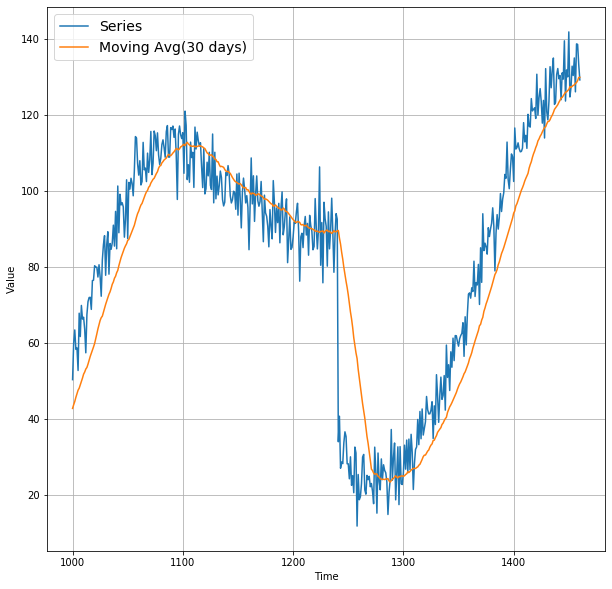

In [16]:
moving_avg = moving_average_forecast(series,30)[split_time-30:]
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,moving_avg,label="Moving Avg(30 days)")

In [17]:
# The plot above shows that the moving avg is not much accurate for steep slopes as told by error below as well
keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()

9.899460832877523

In [18]:
series[365:]

array([ 76.7896275 ,  75.28989132,  79.46687823, ..., 138.55968179,
       133.25353913, 129.21579989])

In [19]:
series[:-365]
list = [1,2,3,4,5,6,7,8,9]
list[:-3]

[1, 2, 3, 4, 5, 6]

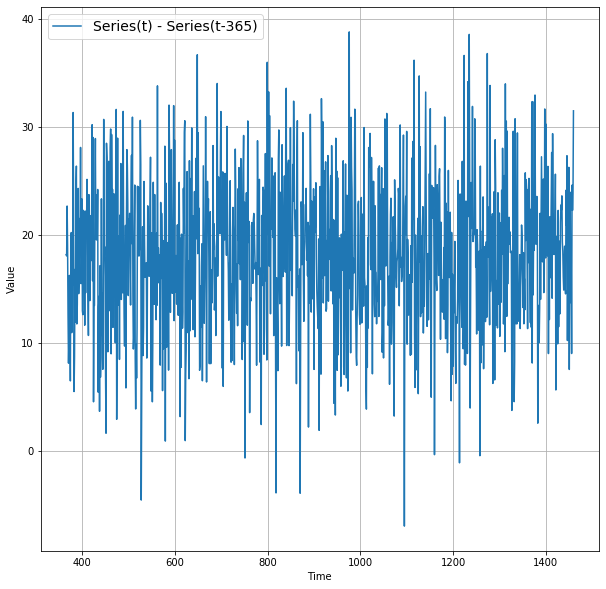

In [30]:
# Removing the seasonality and trend by subtracting the values at (t-365) from those at t
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

# We get only white noise values
plt.figure(figsize=(10,10))
plot_series(diff_time,diff_series,label="Series(t) - Series(t-365)")

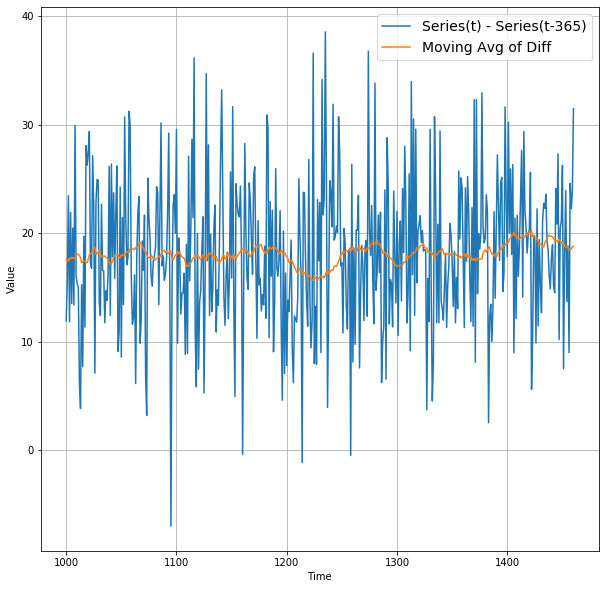

In [21]:
# Taking moving avg of these values
diff_moving_average = moving_average_forecast(diff_series,50)[split_time-50-365:]
plt.figure(figsize=(10,10))
plot_series(time_valid,diff_series[split_time-365:],label="Series(t) - Series(t-365)")
plot_series(time_valid,diff_moving_average,label="Moving Avg of Diff")

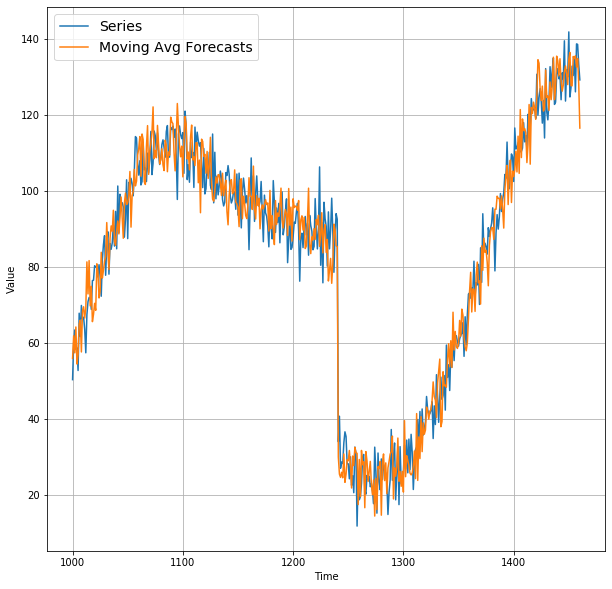

In [22]:
# Now if we again add the subtracted values we get much better moving avg of original series which fits steeper
# slopes better
diff_moving_avg_plus_past = series[split_time-365:-365] + diff_moving_average
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,diff_moving_avg_plus_past,label="Moving Avg Forecasts")

In [23]:
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy()

5.498204145293939

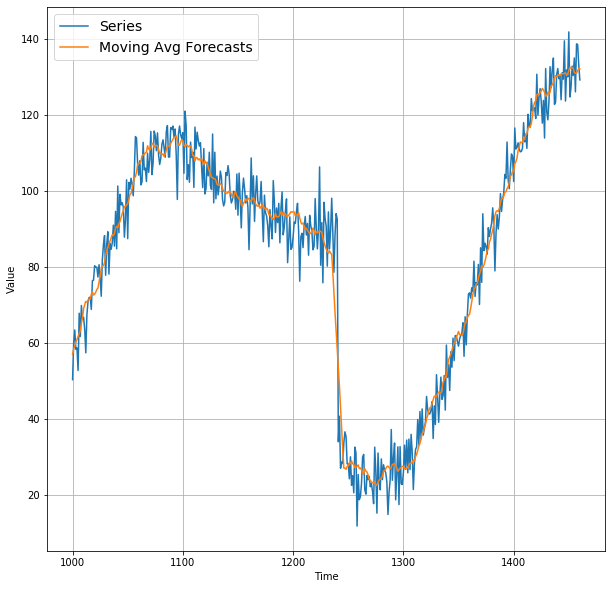

In [33]:
# Finally if we perform moving avg of this forecast we can remove the unncessary noise and get better results
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-370:-359],11) + diff_moving_average
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,diff_moving_avg_plus_smooth_past,label="Moving Avg Forecasts")

In [34]:
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy()

4.477857372384458